In [43]:
# ----- Imports ----- #
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

words = open("names.txt").read().splitlines()

In [44]:
# ----- Vocab Mapping ----- #
chars = sorted(list(set("".join(words))))
string_to_int = {c: i+1 for i, c in enumerate(chars)}
string_to_int["."] = 0
integer_to_string = {i: c for c, i in string_to_int.items()}

In [45]:
# ----- Build Dataset Function ----- #

block_size = 3

def build_dataset(words):
    contexts, targets = [], []
    for word in words:
        context = [0] * block_size
        for char in word + ".":
            int_char = string_to_int[char]
            contexts.append(context)
            targets.append(int_char)
            
            context = context[1:] + [int_char]
    
    contexts = torch.tensor(contexts)
    targets = torch.tensor(targets)
    
    return contexts, targets

# ----- Shuffle and Split Dataset (train: 80%, dev: 10%, test: 10%) ----- #

random.seed(42) # for reproducibility
random.shuffle(words)

train_split_index = int(len(words) * 0.8)
dev_split_index = int(len(words) * 0.9)

X_train, y_train = build_dataset(words[:train_split_index]) # 80% of data
X_dev, y_dev = build_dataset(words[train_split_index:dev_split_index]) # 10% of data
X_test, y_test = build_dataset(words[dev_split_index:]) # 10% of data

In [47]:
# ----- Hyperparameters ----- #
generator = torch.Generator().manual_seed(2147483647) # for reproducibility

vocab_size = len(chars) + 1 # +1 for the padding character
learning_rate = 0.1
mini_batch_size = 32
hidden_size = 200 # neurons in hidden layer
embedding_size = 10 # dimension of embedding vector i.e a -> [0.1, 0.2, 0.3, ...] of shape: (1, embedding_size)

# ----- Generate Initial Model Parameters ----- #

lookup_table = torch.randn((vocab_size, embedding_size), generator=generator)

weights1 = torch.randn((embedding_size*block_size, hidden_size), generator=generator) * (5/3)*((embedding_size*block_size)**0.5) #kaiming init
biases1 = torch.randn(hidden_size, generator=generator) * 0.01

weights2 = torch.randn((hidden_size, vocab_size), generator=generator) * 0.01
biases2 = torch.randn(vocab_size, generator=generator) * 0.0

batch_norm_gain = torch.ones((1,hidden_size))
batch_norm_bias = torch.zeros((1,hidden_size))

parameters = [lookup_table, weights1, biases1, weights2, biases2, batch_norm_gain, batch_norm_bias]
for parameter in parameters:
    parameter.requires_grad = True

In [48]:
# ----- Logging ----- #
lr_exponent = np.linspace(-3, 0, 1000)
lr_iteraters = 10 ** lr_exponent

loss_axis = []
step_axis = []

In [49]:
# ----- Training Loop ----- #

max_steps = 100000

for i in range(max_steps):
    # ----- Mini-batch ----- #
    mini_batch_indicies = torch.randint(0, X_train.shape[0], (mini_batch_size,), generator=generator)
    
    
    # ----- Forward pass ----- #
    embedings = lookup_table[X_train[mini_batch_indicies]]
    # view transforms the tensor into a 2D matrix of [batch_size, block_size*embedding_size]
    embeded_concat = embedings.view(-1,block_size*embedding_size)
    output1_pre = embeded_concat @ weights1 + biases1
    output1_pre = batch_norm_gain * ((output1_pre - output1_pre.mean()) / output1_pre.std()) + batch_norm_bias # batch norm
    output1 = torch.tanh(output1_pre)
    logits = output1 @ weights2 + biases2

    loss = F.cross_entropy(logits, y_train[mini_batch_indicies])
    
    # ----- Backwards pass ----- #
    for parameter in parameters:
        parameter.grad = None

    loss.backward()    

    #learning_rate = lr_iteraters[i] # uncomment for logging
    for parameter in parameters:
        parameter.data -= learning_rate * parameter.grad
        
    # ----- Logging ----- #
    #learning_rate_axis.append(lr_exponent[i])
    loss_axis.append(loss.log10().item())
    step_axis.append(i)
    
    if i % 5000 == 0: # every 5000 steps log the loss
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}') # print(step/max_steps: loss)
    loss_axis.append(loss.log10().item()) # log10 smooths out loss curve

      0/ 100000: 3.3113
   5000/ 100000: 2.2925
  10000/ 100000: 2.1535
  15000/ 100000: 2.2057
  20000/ 100000: 2.3715
  25000/ 100000: 2.2751
  30000/ 100000: 2.5858
  35000/ 100000: 2.4493
  40000/ 100000: 1.9727
  45000/ 100000: 1.8123
  50000/ 100000: 2.5283
  55000/ 100000: 2.1224
  60000/ 100000: 2.3814
  65000/ 100000: 1.9456
  70000/ 100000: 2.1330
  75000/ 100000: 2.6134
  80000/ 100000: 2.3786
  85000/ 100000: 2.1904
  90000/ 100000: 2.1835
  95000/ 100000: 2.0776


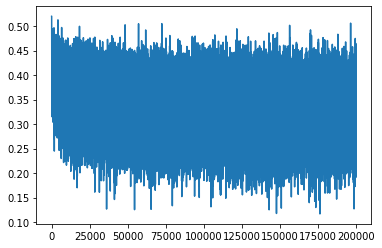

In [ ]:
plt.plot(loss_axis)